# Selecting stations

In [1]:
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np
#import shapefile as shp
import seaborn as sns
import math

from sklearn import preprocessing
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors.nearest_centroid import NearestCentroid

from shapely.geometry import Point, Polygon
from geopandas import GeoDataFrame
import json
pd.options.display.max_columns = 500


In [2]:
connection = psycopg2.connect(user = "equipo7",
                            password = "DLgndXy2m4hbWH-qn-Co",
                            host= "ds4a-demo-instance.cssn41frspmj.us-east-1.rds.amazonaws.com",
                            port = "5432",
                            database = "anahuac")
cursor = connection.cursor()
def runquery(query):
    df=pd.read_sql(query,connection)
    return df

In [3]:
sqlQuery_stations = "select * from stations.stations_cdmx;"
df_stations = pd.DataFrame(runquery(sqlQuery_stations))
df_stations.head()

,index,cve_estac,nom_estac,longitud,latitud,alt,obs_estac,id_station,geometry
0,0,ACO,Acolman,-98.912003,19.635501,2198.0,None,484150020109,0101000020E6100000A6B6D4415EBA58C047938B31B0A2...
1,1,AJU,Ajusco,-99.162611,19.154286,2942.0,None,484090120400,0101000020E610000012BEF73768CA58C00C3B8C497F27...
2,2,AJM,Ajusco Medio,-99.207744,19.272161,2548.0,None,484090120609,0101000020E61000002C7C7DAD4BCD58C0253FE257AC45...
3,3,ARA,Aragón,-99.074549,19.470218,2200.0,Finalizó operación en 2010,484090050301,0101000020E6100000C53C2B69C5C458C093FDF3346078...
4,4,ATI,Atizapan,-99.254133,19.576963,2341.0,None,484150130101,0101000020E610000066F50EB743D058C08600E0D8B393...


In [4]:
df_stations.shape

(69, 9)

In [5]:
df_stations.alt.isnull().sum()

1

In [6]:
df_stations.alt.fillna(df_stations.alt.mean(), inplace=True)

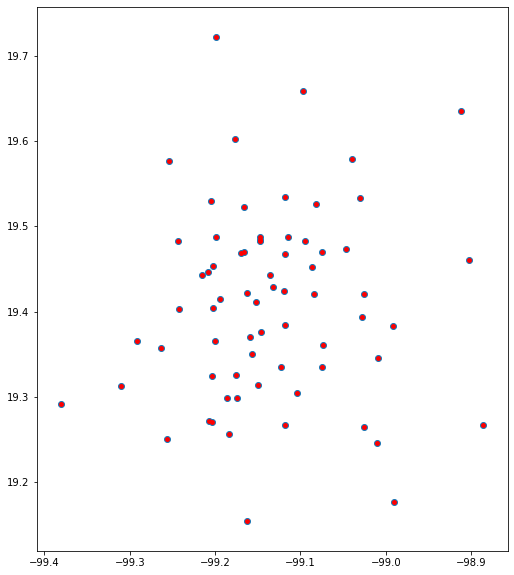

In [7]:
geometry = [Point(xy) for xy in zip(df_stations['longitud'], df_stations['latitud'])]
gdf = GeoDataFrame(df_stations, geometry=geometry)   
gdf.plot(ax=gdf.plot(figsize=(15, 10)), marker='o', color='red', markersize=15);

# Set the filepath, load and prepare data to show map

In [8]:
fp_shape = "CDMX/CDMX.shp" 
map_df = gpd.read_file(fp_shape)
stations_points = df_stations[['longitud', 'latitud']].apply(lambda row: Point(row["longitud"], row["latitud"]), axis=1)
geo_stations = gpd.GeoDataFrame({"geometry": stations_points, "Stations": df_stations["cve_estac"]})
cdmx_stations = gpd.tools.sjoin(geo_stations, map_df, how="right", op='intersects')


/Users/fernandomelchor/opt/anaconda3/lib/python3.7/site-packages/geopandas/tools/sjoin.py:61: UserWarning: CRS of frames being joined does not match!(None != {'init': 'epsg:4326'})
  "(%s != %s)" % (left_df.crs, right_df.crs)


# Visualize stations on mexico city shape map

Text(0.5, 1, 'CDMX Stations')

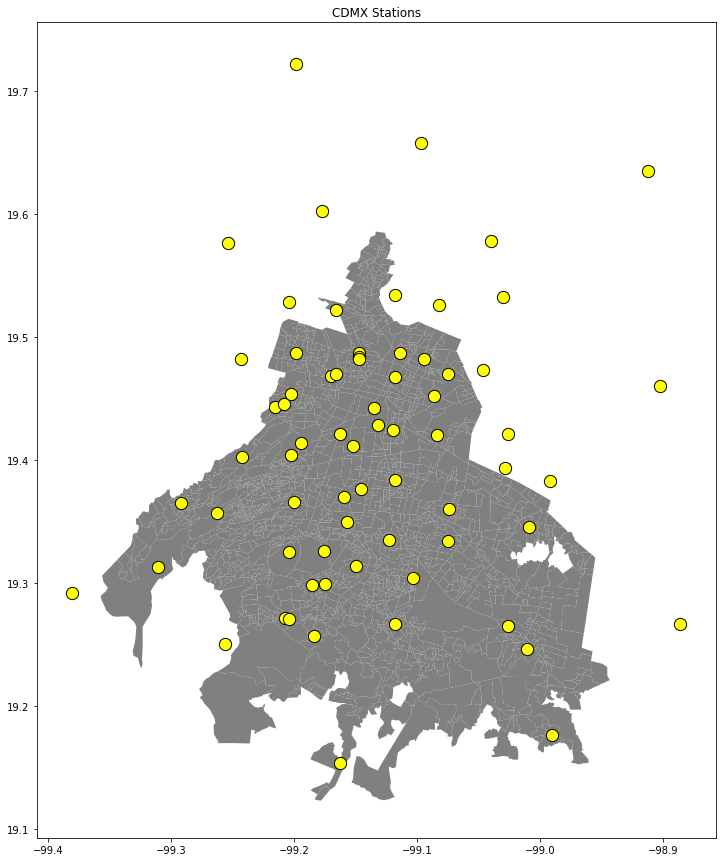

In [9]:
#https://shapesdemexico.wixsite.com/shapes/colonias-por-estado
fig, ax = plt.subplots(1,figsize = (30, 15))
base = map_df.plot(ax=ax, color='gray')
geo_stations.plot(ax=base,  marker='o', color='yellow', edgecolor='#000000', markersize=150)
#_ = ax.axis('off')
ax.set_title("CDMX Stations")

Text(0.5, 1, 'CDMX Stations')

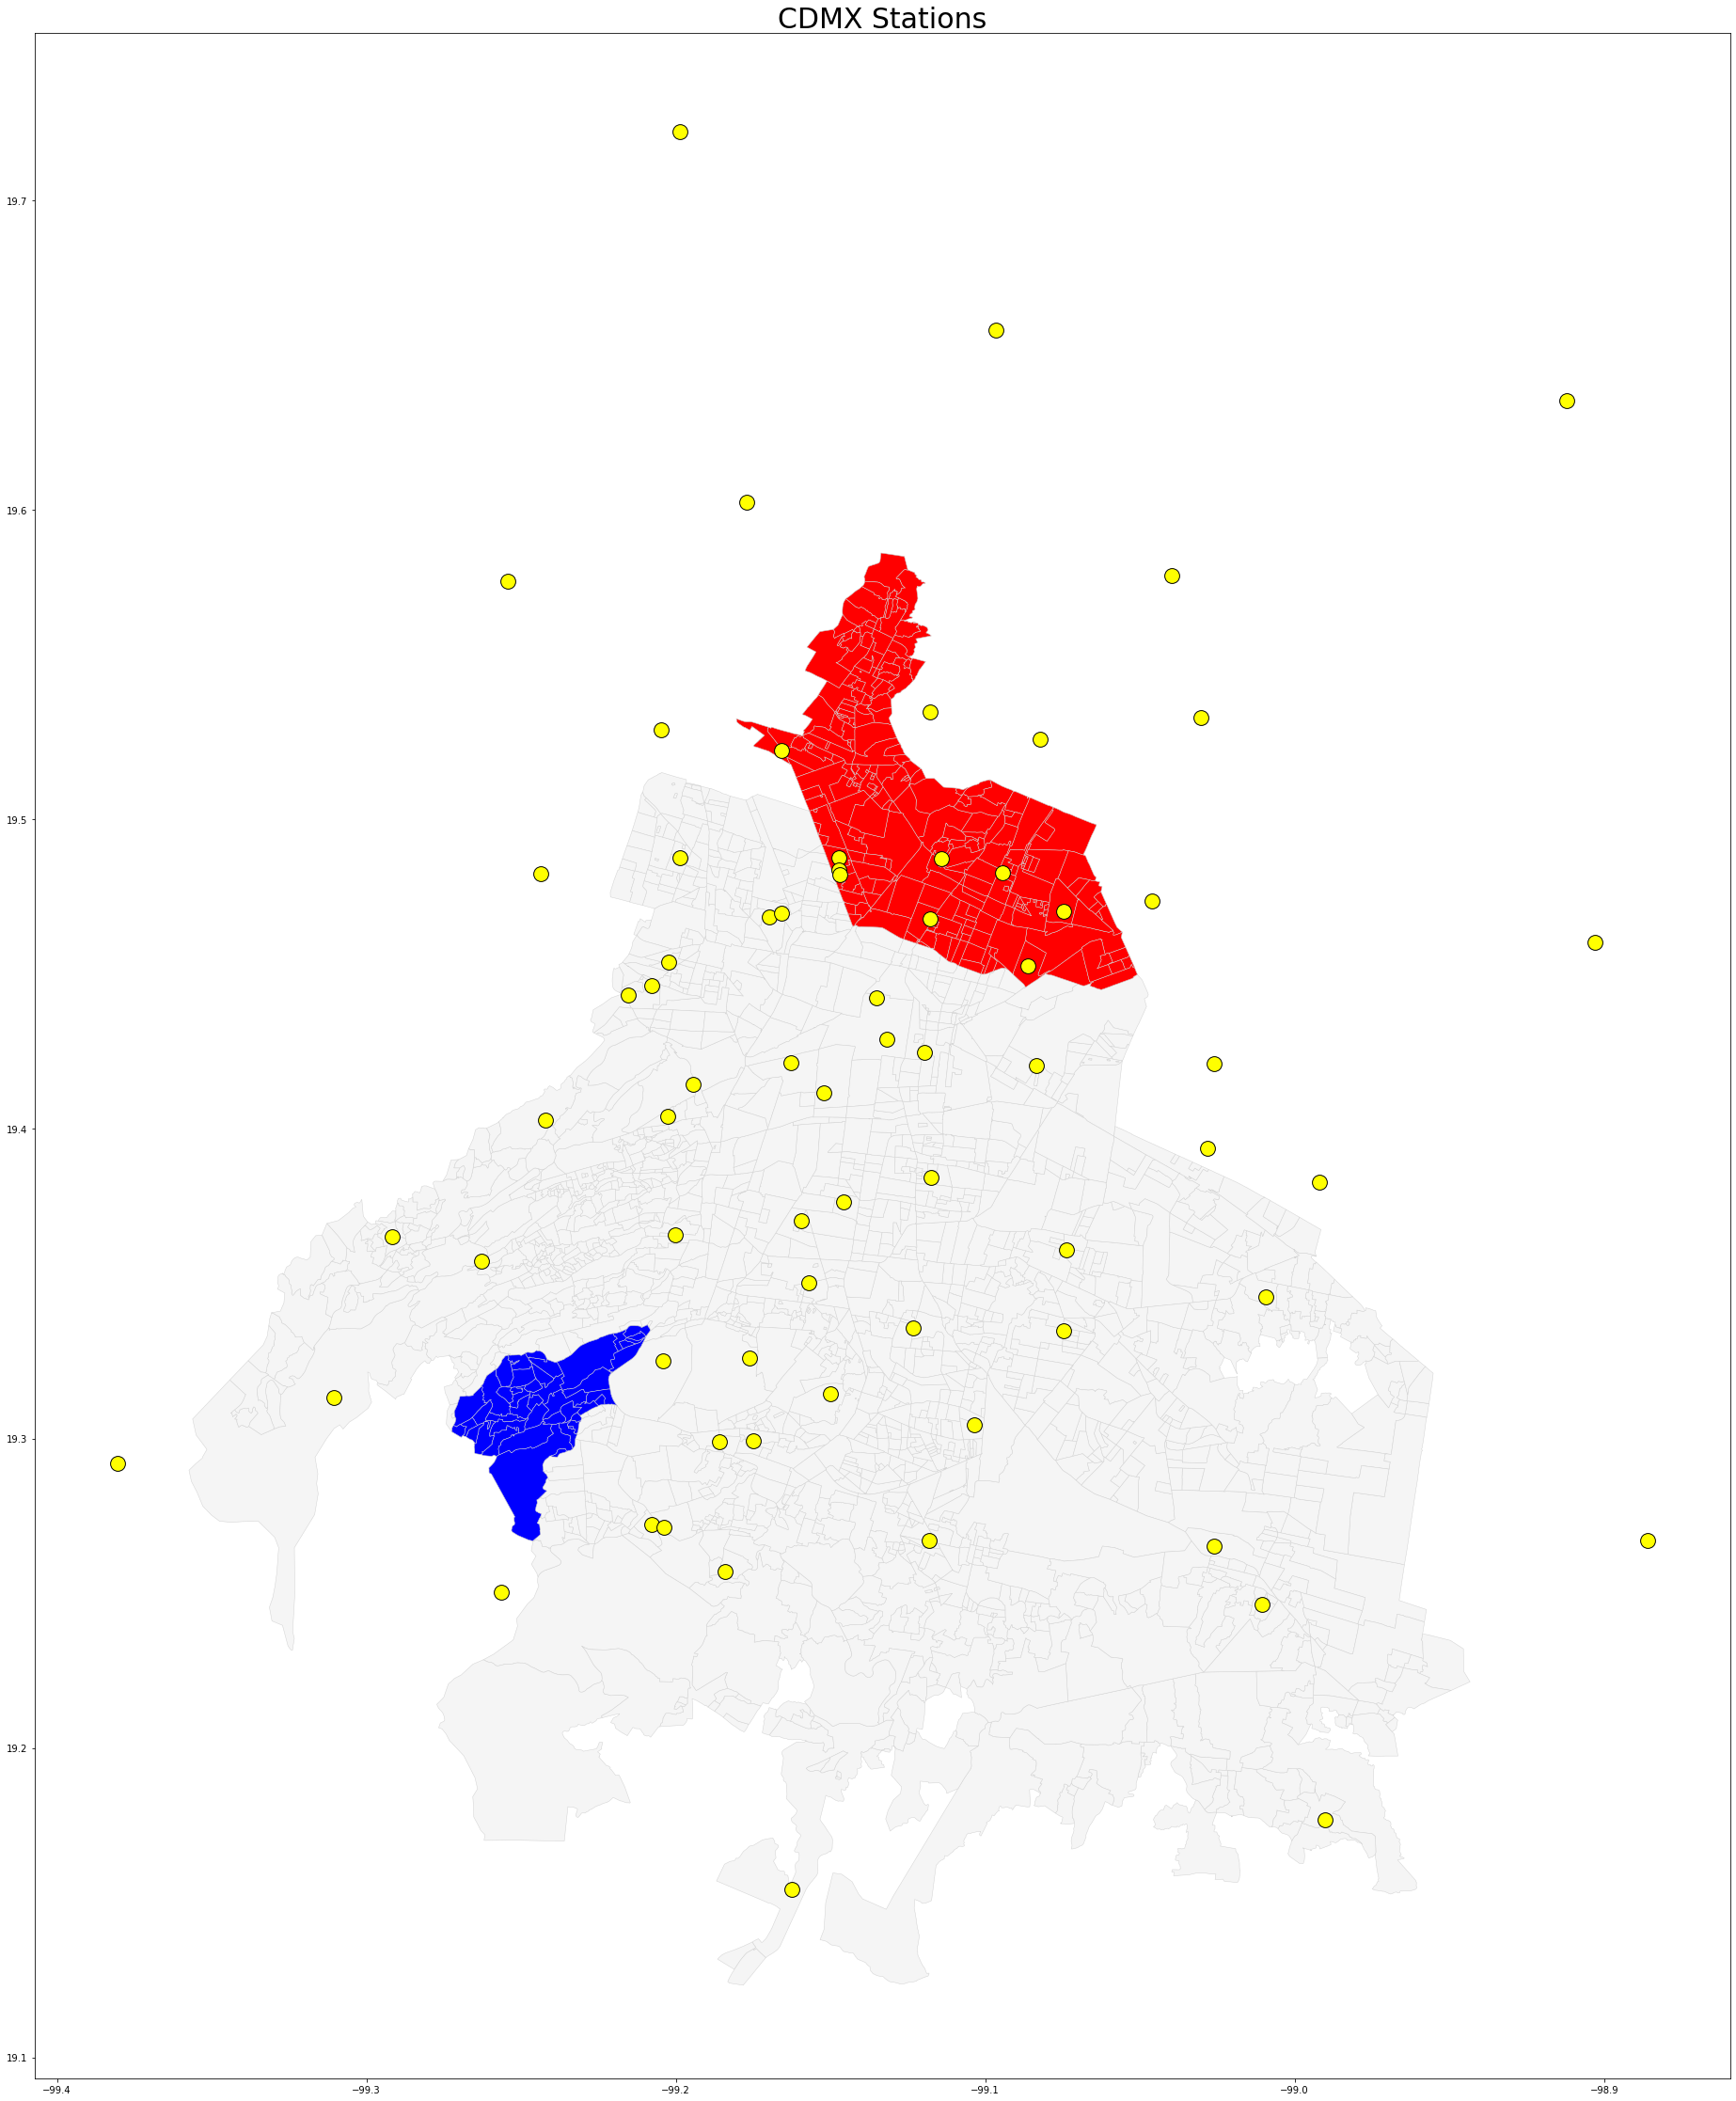

In [10]:
fig, ax = plt.subplots(1,figsize = (50, 40))
base = map_df.plot(ax=ax, color = "whitesmoke", edgecolor = "lightgrey", linewidth = 0.5)
cdmx_stations[cdmx_stations["MUN_NAME"] == "GUSTAVO A MADERO"].plot(ax = ax, color = "red", edgecolor = "lightgrey", linewidth = 0.5)
cdmx_stations[cdmx_stations["MUN_NAME"] == "LA MAGDALENA CONTRERAS"].plot(ax = ax, color = "blue", edgecolor = "lightgrey", linewidth = 0.5)
geo_stations.plot(ax=base,  marker='o', color='yellow', edgecolor='#000000', markersize=250)
ax.set_title("CDMX Stations", size = 30)

# Number of stations by "alcaldia"

/Users/fernandomelchor/opt/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 129 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/fernandomelchor/opt/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 137 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/fernandomelchor/opt/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 147 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/fernandomelchor/opt/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 129 missing from current font.
  font.set_text(s, 0, flags=flags)
/Users/fernandomelchor/opt/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 137 missing from current font.
  font.set_text(s, 0, flags=flags)
/Users/fernandomelchor/opt/an

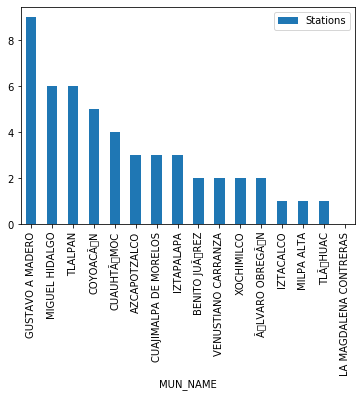

In [11]:
fig, ax = plt.subplots()
t = pd.DataFrame(cdmx_stations.groupby('MUN_NAME').Stations.nunique()).sort_values(['Stations'],ascending=False)
t.plot(ax=ax, kind='bar')

# Normalize data to cluster points

In [12]:
"""convert spherical arc length [m] to great circle distance [deg]"""
def arc_to_deg(arc):
    return float(arc)/6371/1000 * 180/math.pi

"""convert great circle distance [deg] to spherical arc length [m]"""
def deg_to_arc(deg):
    return float(deg)*6371*1000 * math.pi/180

"""Convert angular to cartesian coordiantes
    latitude is the 90deg - zenith angle in range [-90;90]
    lonitude is the azimuthal angle in range [-180;180] 
    """
def latlon_to_xyz(lat,lon):
    r = 6371 # https://en.wikipedia.org/wiki/Earth_radius
    theta = math.pi/2 - math.radians(lat) 
    phi = math.radians(lon)
    x = r * math.sin(theta) * math.cos(phi) # bronstein (3.381a)
    y = r * math.sin(theta) * math.sin(phi)
    z = r * math.cos(theta)
    return [x,y,z]

"""Convert cartesian to angular lat/lon coordiantes"""
def xyz_to_latlon (x,y,z):    
    r = math.sqrt(x**2 + y**2 + z**2)
    theta = math.asin(z/r) # https://stackoverflow.com/a/1185413/4933053
    phi = math.atan2(y,x)
    lat = math.degrees(theta)
    lon = math.degrees(phi)
    return [lat,lon]

"""Get centroid from list of coordinates"""
def get_centroid( n_clusters_ , labels,  X):
    len_list = list()
    for i in range(n_clusters_):
        len_list.append(center_np(X[labels == i]))
    return len_list    

"""Center as mean"""
def center_np(data):
    return np.mean(data, axis=0) 

In [13]:
from numpy import linspace
from matplotlib import cm
from scipy.spatial import ConvexHull

# Encircle
def encircle(x,y, ax=None, **kw):
    if not ax: ax=plt.gca()
    p = np.c_[x,y]
    hull = ConvexHull(p)
    poly = plt.Polygon(p[hull.vertices,:], **kw)
    ax.add_patch(poly)

#gives pretty colors to dbscan     
def my_pretty_dbscan_hierarchical_cluster_plot(n_clusters, df, x_label, y_label, category_label, title, marker_symbol):
    my_colors = ['gold','blue','red','green','purple', 'khaki', 'dodgerblue','firebrick', 'lawngreen','indigo', 'cyan','magenta']
    #colors = [ cm.jet(x) for x in linspace(0, 1, n_clusters) ]  
    #colors = cm.rainbow(np.linspace(0,1,n_clusters))
    plt.gca().set_title(title)
    for i in range(n_clusters) :
        category =  df[category_label] == i
        plt.scatter(df[category][x_label], df[category][y_label], marker=marker_symbol, color=my_colors[i])
        encircle(df[category][x_label], df[category][y_label], ec="k", fc=my_colors[i], alpha=0.2, linewidth=0)
        
my_colors = ['gold','blue','red','green','purple', 'khaki', 'dodgerblue','firebrick', 'lawngreen','indigo', 'cyan','magenta']       

#gives pretty colors to dbscan     
def my_pretty_dbscan_hierarchical_cluster_plot(n_clusters, df, x_label, y_label, category_label, title, marker_symbol):
    #my_colors = [ cm.jet(x) for x in linspace(0, 1, n_clusters) ]  
    #my_colors = cm.rainbow(np.linspace(0,1,n_clusters))
    plt.gca().set_title(title)
    for i in range(n_clusters) :
        category =  df[category_label] == i
        plt.scatter(df[category][x_label], df[category][y_label], marker=marker_symbol, color=my_colors[i])
        encircle(df[category][x_label], df[category][y_label], ec="k", fc=my_colors[i], alpha=0.2, linewidth=0)    
        
        
def my_pretty_dbscan_hierarchical_cluster_centroids_plot(n_clusters, df, x_label, y_label, category_label, title, marker_symbol):
    my_marker_size = 5
    plt.gca().set_title(title)
    for i in range(n_clusters) :
        category =  df[category_label] == i
        plt.scatter(df[category][x_label], df[category][y_label], marker=marker_symbol, s=my_marker_size,color=my_colors[i])
        plt.scatter(df[category][x_label].mean(), df[category][y_label].mean(), marker=marker_symbol, s=my_marker_size*10, color=my_colors[i])
        encircle(df[category][x_label], df[category][y_label], ec="k", fc=my_colors[i], alpha=0.2, linewidth=0)    
        
             
        

# Get x,y,z coordinates based on latitude and longitude

In [14]:
#df_stations.alt.fillna(df_stations.alt.mean(), inplace=True)

In [15]:
df_stations.shape

(69, 9)

In [16]:
from sklearn import preprocessing
lon_scale = preprocessing.StandardScaler().fit(df_stations.longitud.values.reshape(-1, 1))
lon_std = lon_scale.transform(df_stations.longitud.values.reshape(-1, 1))
lat_scale = preprocessing.StandardScaler().fit(df_stations.latitud.values.reshape(-1, 1))
lat_std = lat_scale.transform(df_stations.latitud.values.reshape(-1, 1))
al_scale = preprocessing.StandardScaler().fit(df_stations.alt.values.reshape(-1, 1))
al_std = al_scale.transform(df_stations.alt.values.reshape(-1, 1))
lon_std = [i[0] for i in lon_std]
lat_std = [i[0] for i in lat_std]
al_std = [i[0] for i in al_std]

In [17]:
df_stations['x'] =lon_std
df_stations['y'] = lat_std
df_stations['z'] = al_std

In [18]:
df_normalized_converted_stations = df_stations.copy(deep=True)

In [19]:
# df_normalized_converted_stations =  df_stations.join( pd.DataFrame( df_stations.apply(lambda row: latlon_to_xyz(row['latitud'], row['longitud']), axis=1).tolist() ,columns=list('xyz')))
df_normalized_converted_stations.head()

,index,cve_estac,nom_estac,longitud,latitud,alt,obs_estac,id_station,geometry,x,y,z
0,0,ACO,Acolman,-98.912003,19.635501,2198.0,None,484150020109,POINT (-98.91200 19.63550),2.434452,2.035604,-0.703592
1,1,AJU,Ajusco,-99.162611,19.154286,2942.0,None,484090120400,POINT (-99.16261 19.15429),-0.290157,-2.293518,3.165130
2,2,AJM,Ajusco Medio,-99.207744,19.272161,2548.0,None,484090120609,POINT (-99.20774 19.27216),-0.780843,-1.233087,1.116372
3,3,ARA,Aragón,-99.074549,19.470218,2200.0,Finalizó operación en 2010,484090050301,POINT (-99.07455 19.47022),0.667253,0.548680,-0.693192
4,4,ATI,Atizapan,-99.254133,19.576963,2341.0,None,484150130101,POINT (-99.25413 19.57696),-1.285184,1.508983,0.039993


# 3D Plot to check height variable 

In [20]:
from mpl_toolkits.mplot3d import Axes3D

def plot_3d(xcol,ycol,zcol,my_title,colorbyz=True, colorbydata=None):
    x_ = np.array(xcol)
    y_ = np.array(ycol)
    z_ = np.array(zcol)
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    if colorbyz :
        ax.scatter(x_, y_, z_, marker="s", s=30, c=z_, cmap="rainbow")
    else :
        if colorbydata is not None:
            ax.scatter(x_, y_, z_, marker="s", s=30, c=colorbydata, cmap="rainbow")
        else :
            print("Error")
    plt.gca().set_title(my_title)
    plt.show()

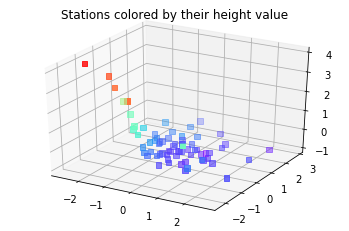

In [21]:
plot_3d(df_normalized_converted_stations['x'],
        df_normalized_converted_stations['y'],
        df_normalized_converted_stations['z'],
        'Stations colored by their height value', 
        colorbyz=True)



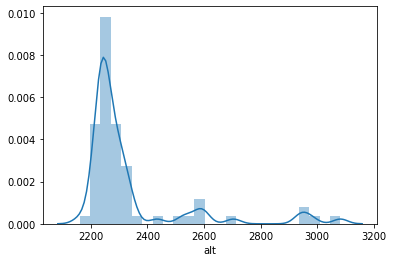

In [22]:
sns.distplot(df_normalized_converted_stations['alt'])

# Get stations that have height < 2300

In [23]:
filter_stations =  df_normalized_converted_stations['alt'] < 2400
df_normalized_converted_stations = df_normalized_converted_stations[filter_stations]

# Check height for nulls before performing clustering

In [24]:
df_normalized_converted_stations.alt.isnull().sum()

0

In [25]:
df_normalized_converted_stations.shape

(58, 12)

In [26]:
df_normalized_converted_stations.head()

,index,cve_estac,nom_estac,longitud,latitud,alt,obs_estac,id_station,geometry,x,y,z
0,0,ACO,Acolman,-98.912003,19.635501,2198.0,None,484150020109,POINT (-98.91200 19.63550),2.434452,2.035604,-0.703592
3,3,ARA,Aragón,-99.074549,19.470218,2200.0,Finalizó operación en 2010,484090050301,POINT (-99.07455 19.47022),0.667253,0.548680,-0.693192
4,4,ATI,Atizapan,-99.254133,19.576963,2341.0,None,484150130101,POINT (-99.25413 19.57696),-1.285184,1.508983,0.039993
5,5,AZC,Azcapotzalco,-99.198657,19.487728,2279.0,Finalizó operación en 2010,484090020201,POINT (-99.19866 19.48773),-0.682049,0.706204,-0.282400
6,6,BJU,Benito Juárez,-99.159596,19.370464,2249.0,Finalizó operación en 2005,484090140201,POINT (-99.15960 19.37046),-0.257378,-0.348730,-0.438397


# Clustering to select some stations using x,y,height variables

In [27]:
#df_normalized_converted_stations[['x','y','z']].values

Number of stations before clustering: 69


/Users/fernandomelchor/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


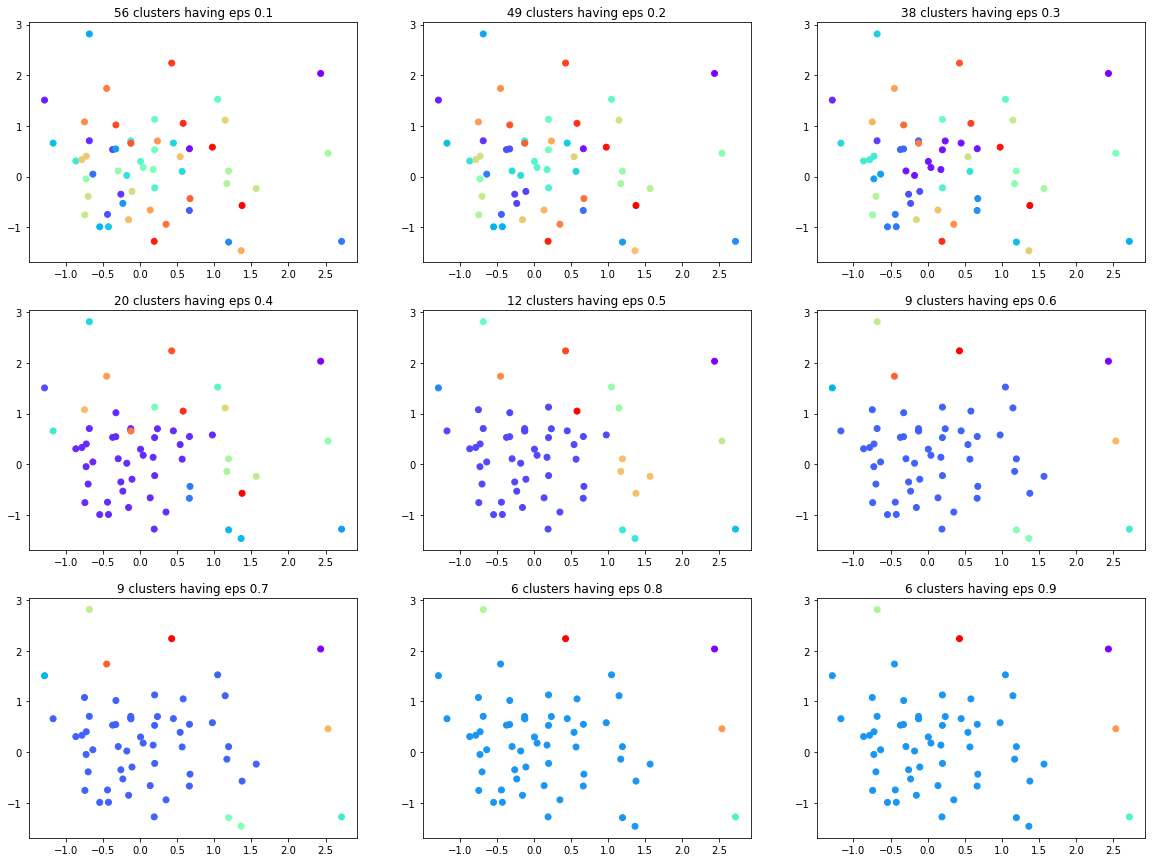

In [28]:
dbscan = DBSCAN()
#X = preprocessing.scale(df_normalized_converted_stations[['x','y','alt']])
#X = StandardScaler().fit_transform(df_normalized_converted_stations[['x','y','z']])
X =df_normalized_converted_stations[['x','y','z']].values
print('Number of stations before clustering: {}'.format( len(df_stations) ))

cluster_coor_len_list = []
cluster_fig = plt.figure(figsize=(20, 15))
nrows, ncols = 3, 3 
for idx in range(0,9):
    current_eps = (idx+1)/10
    y_pred = DBSCAN( eps = current_eps, min_samples=1 ).fit_predict(X)
    labels = y_pred[np.where(y_pred != -1)]
    ax = cluster_fig.add_subplot(nrows, ncols, idx + 1)
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    plt.gca().set_title('{} clusters having eps {}'.format( n_clusters_ ,  current_eps ))
    plt.scatter(X[:,0], X[:,1], c=y_pred, cmap='rainbow', marker='o')
    
    #save points 
    cluster_coor_len_list.append( get_centroid(n_clusters_,labels, X)    )
        
cluster_fig.show()

/Users/fernandomelchor/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  # This is added back by InteractiveShellApp.init_path()


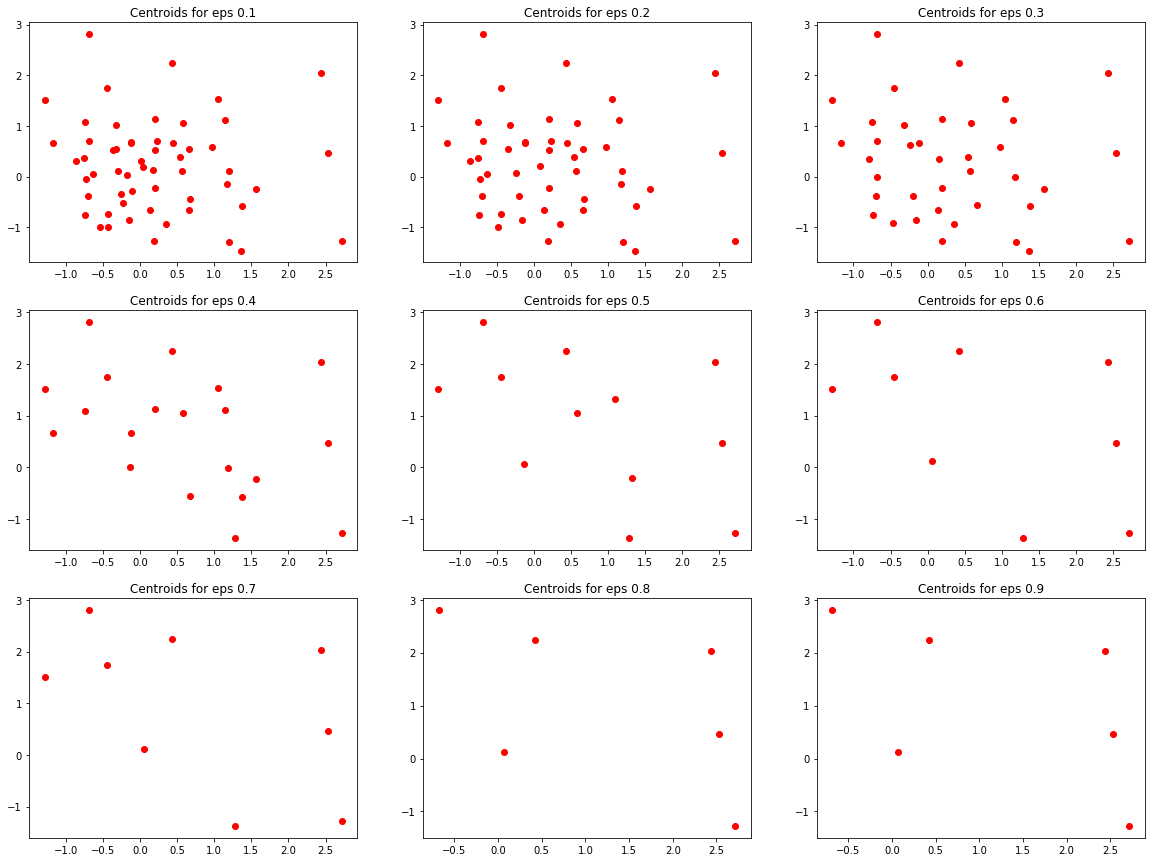

In [29]:
centroids_fig = plt.figure(figsize=(20, 15))
nrows, ncols = 3, 3 
for idx in range(0,9):
    current_eps = (idx+1)/10
    coords = cluster_coor_len_list[idx]
    temp_df = pd.DataFrame()
    temp_df[['x','y','z']] = pd.DataFrame(np.vstack(coords))
    ax_centroid = centroids_fig.add_subplot(nrows, ncols, idx + 1)
    plt.gca().set_title('Centroids for eps {}'.format(current_eps))
    plt.scatter(temp_df['x'], temp_df['y'], marker='o', color='red')
centroids_fig.show()


# Hierarchical clustering

Text(0, 0.5, 'Euclidean distance in the space with other variables')

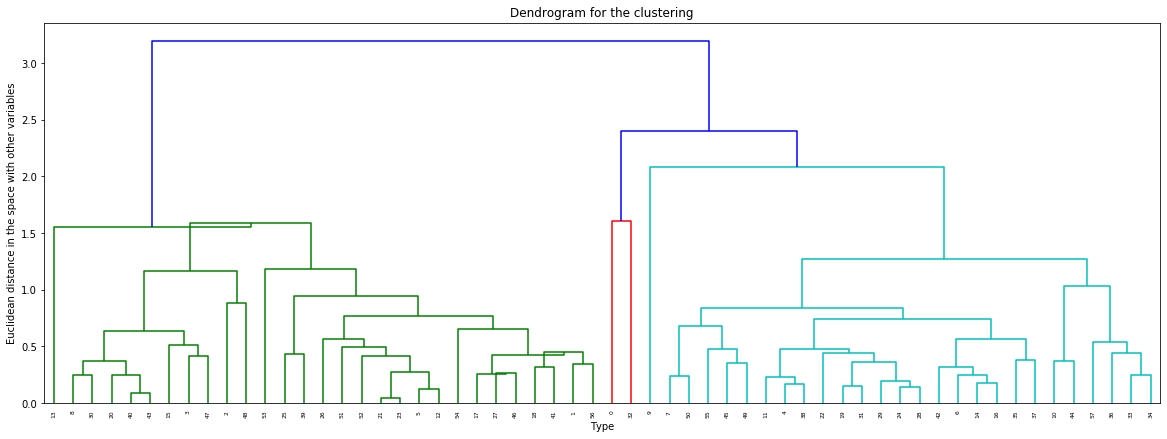

In [30]:
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch
Z = sch.linkage(X, method = 'median')
plt.figure(figsize=(20,7))
den = sch.dendrogram(Z)
plt.title('Dendrogram for the clustering')
plt.xlabel('Type')
plt.ylabel('Euclidean distance in the space with other variables')

# Determining number of clusters

In [31]:
#this can be changed and all code below will be affected
how_many_clusters = 3

cluster_H = AgglomerativeClustering(n_clusters=how_many_clusters)
model_clt = cluster_H.fit(X)
pred1 = model_clt.labels_

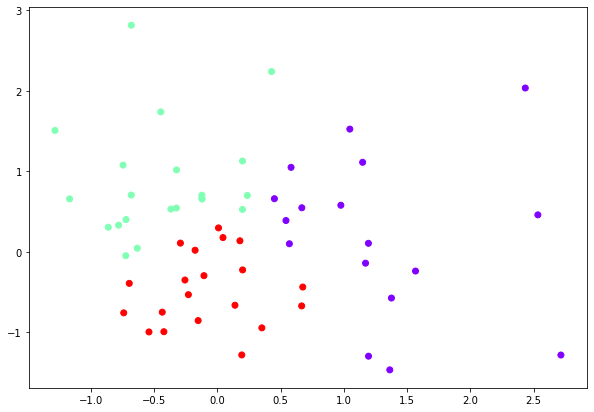

In [32]:
plt.figure(figsize=(10, 7))
plt.scatter(X[:,0],X[:,1], c=pred1, cmap='rainbow')

# 3D Cluster Plot 

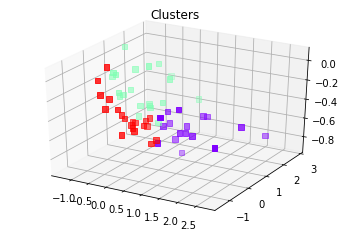

In [33]:
plot_3d(X[:,0],X[:,1],X[:,2],'Clusters', colorbyz=False, colorbydata=pred1)

In [34]:
clustering_resul_df = pd.DataFrame()
clustering_resul_df[['x','y','z']] = pd.DataFrame(np.vstack(X))
clustering_resul_df['category'] =  pd.DataFrame(np.vstack(pred1))
clustering_resul_df

,x,y,z,category
0,2.434452,2.035604,-0.703592,0
1,0.667253,0.548680,-0.693192,0
2,-1.285184,1.508983,0.039993,1
3,-0.682049,0.706204,-0.282400,1
4,-0.257378,-0.348730,-0.438397,2
5,-0.368250,0.532361,-0.521595,1
6,-0.436929,-0.747740,-0.204402,2
7,0.665850,-0.670193,-0.594394,2
8,-0.634451,0.046465,-0.240801,1
9,2.716200,-1.279984,-0.417597,0


# Defining clusters and get centroids

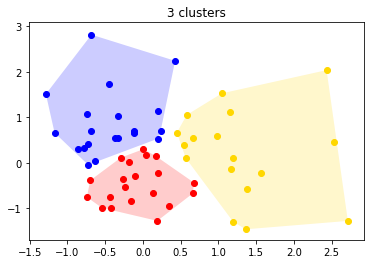

In [35]:
my_pretty_dbscan_hierarchical_cluster_plot(how_many_clusters, clustering_resul_df, 'x','y','category', '{} clusters'.format(how_many_clusters),'o')


In [37]:
how_many_clusters

3

In [39]:
#clustering_resul_df

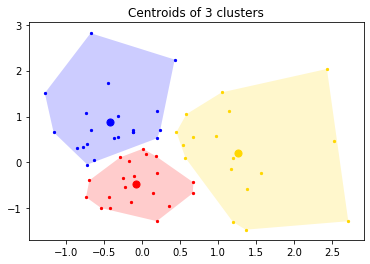

In [36]:
my_pretty_dbscan_hierarchical_cluster_centroids_plot(how_many_clusters, clustering_resul_df, 'x','y','category', 'Centroids of {} clusters'.format(how_many_clusters),'o')




In [122]:
clustering_resul_df.head()

,x,y,z,category
0,2.434452,2.035604,-0.703592,0
1,0.667253,0.548680,-0.693192,0
2,-1.285184,1.508983,0.039993,1
3,-0.682049,0.706204,-0.282400,1
4,-0.257378,-0.348730,-0.438397,2


In [59]:
df_normalized_converted_stations = df_normalized_converted_stations.merge(clustering_resul_df, on=['x','y','z'])

# Assigning category to dataframe

In [60]:
#df_normalized_converted_stations['category'] = pd.Series(clustering_resul_df['category'], index=df_normalized_converted_stations.index)
df_normalized_converted_stations.head()

,index,cve_estac,nom_estac,longitud,latitud,alt,obs_estac,id_station,geometry,x,y,z,category
0,0,ACO,Acolman,-98.912003,19.635501,2198.0,None,484150020109,POINT (-98.91200 19.63550),2.434452,2.035604,-0.703592,0
1,3,ARA,Aragón,-99.074549,19.470218,2200.0,Finalizó operación en 2010,484090050301,POINT (-99.07455 19.47022),0.667253,0.548680,-0.693192,0
2,4,ATI,Atizapan,-99.254133,19.576963,2341.0,None,484150130101,POINT (-99.25413 19.57696),-1.285184,1.508983,0.039993,1
3,5,AZC,Azcapotzalco,-99.198657,19.487728,2279.0,Finalizó operación en 2010,484090020201,POINT (-99.19866 19.48773),-0.682049,0.706204,-0.282400,1
4,6,BJU,Benito Juárez,-99.159596,19.370464,2249.0,Finalizó operación en 2005,484090140201,POINT (-99.15960 19.37046),-0.257378,-0.348730,-0.438397,2


In [61]:
df_normalized_converted_stations.shape

(58, 13)

In [62]:
#df_normalized_converted_stations

# 3D Plot to check final clustered data  

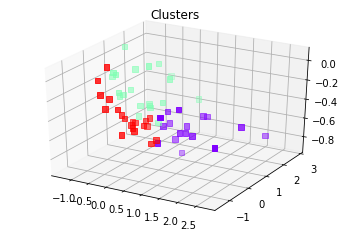

In [63]:
plot_3d(df_normalized_converted_stations['x'],
        df_normalized_converted_stations['y'],
        df_normalized_converted_stations['z'],
        'Clusters', 
        colorbyz=False, 
        colorbydata=df_normalized_converted_stations['category'])

# View clusters on map

Text(0.5, 1, 'CDMX Stations')

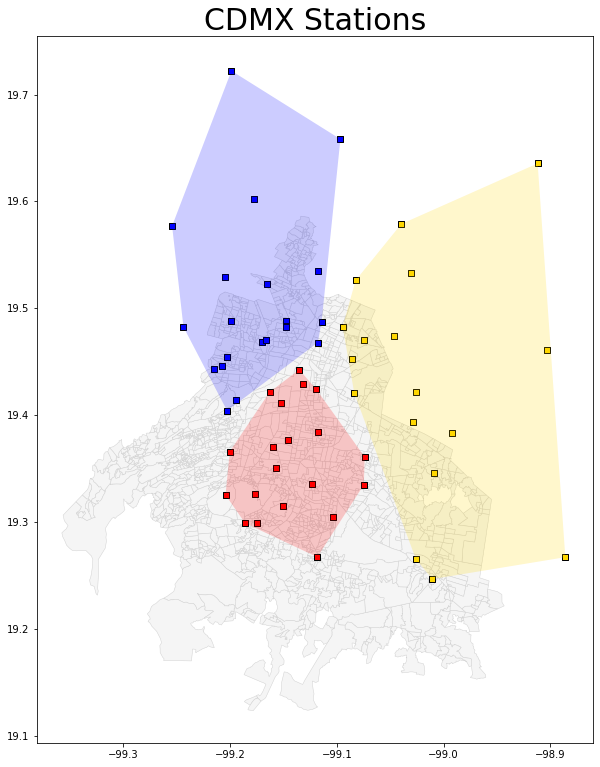

In [64]:
fig, ax = plt.subplots(1,figsize = (15, 13))
base = map_df.plot(ax=ax, color = "whitesmoke", edgecolor = "lightgrey", linewidth = 0.5)
for i in range(how_many_clusters) :
        category =  df_normalized_converted_stations['category'] == i
        plt.scatter(df_normalized_converted_stations[category]['longitud'], df_normalized_converted_stations[category]['latitud'], marker='s', edgecolor='#000000', color=my_colors[i])
        encircle(df_normalized_converted_stations[category]['longitud'], df_normalized_converted_stations[category]['latitud'], ec="k", fc=my_colors[i], alpha=0.2, linewidth=0)    
ax.set_title("CDMX Stations", size = 30)

In [65]:
st = df_normalized_converted_stations.copy(deep=True)

In [67]:
st.head()

,index,cve_estac,nom_estac,longitud,latitud,alt,obs_estac,id_station,geometry,x,y,z,category
0,0,ACO,Acolman,-98.912003,19.635501,2198.0,None,484150020109,POINT (-98.91200 19.63550),2.434452,2.035604,-0.703592,0
1,3,ARA,Aragón,-99.074549,19.470218,2200.0,Finalizó operación en 2010,484090050301,POINT (-99.07455 19.47022),0.667253,0.548680,-0.693192,0
2,4,ATI,Atizapan,-99.254133,19.576963,2341.0,None,484150130101,POINT (-99.25413 19.57696),-1.285184,1.508983,0.039993,1
3,5,AZC,Azcapotzalco,-99.198657,19.487728,2279.0,Finalizó operación en 2010,484090020201,POINT (-99.19866 19.48773),-0.682049,0.706204,-0.282400,1
4,6,BJU,Benito Juárez,-99.159596,19.370464,2249.0,Finalizó operación en 2005,484090140201,POINT (-99.15960 19.37046),-0.257378,-0.348730,-0.438397,2


In [82]:
c0 = st[st.category==0][['longitud','latitud']].mean()
c0['cluster'] = 'st0'
c1 = st[st.category==1][['longitud','latitud']].mean()
c1['cluster'] = 'st1'
c2 = st[st.category==2][['longitud','latitud']].mean()
c2['cluster'] = 'st2'

centroid = pd.DataFrame([c0,c1,c2])

def get_point(row):
    return Point(row['longitud'],row['latitud'])

centroid['geometry']=centroid.apply(lambda row: get_point(row), axis=1)

In [71]:
import shapely
def get_wkt(x):
    if (type(x)!=shapely.geometry.polygon.Polygon)&(type(x)!=shapely.geometry.multipolygon.MultiPolygon)&(type(x)!=shapely.geometry.point.Point):
        return ''
    else:
        return x.wkt
st['geometry_wkt'] = st.geometry.apply(lambda x: get_wkt(x))
st.geometry_wkt= st.geometry_wkt.apply(lambda x: str(x))
print(st.dtypes)

index              int64
cve_estac         object
nom_estac         object
longitud         float64
latitud          float64
alt              float64
obs_estac         object
id_station         int64
geometry        geometry
x                float64
y                float64
z                float64
category           int64
geometry_wkt      object
dtype: object


In [83]:
centroid['geometry_wkt'] =centroid.geometry.apply(lambda x: get_wkt(x))
centroid.geometry_wkt= centroid.geometry_wkt.apply(lambda x: str(x))

In [84]:
centroid.drop('geometry', inplace=True, axis=1)
print(centroid.dtypes)
centroid.geometry_wkt.replace('',np.nan, inplace=True)

longitud        float64
latitud         float64
cluster          object
geometry_wkt     object
dtype: object


In [72]:
st.drop('geometry', inplace=True, axis=1)
print(st.dtypes)
st.geometry_wkt.replace('',np.nan, inplace=True)

index             int64
cve_estac        object
nom_estac        object
longitud        float64
latitud         float64
alt             float64
obs_estac        object
id_station        int64
x               float64
y               float64
z               float64
category          int64
geometry_wkt     object
dtype: object


In [73]:
st.geometry_wkt= st.geometry_wkt.apply(lambda x: str(x))
print(st.dtypes)

index             int64
cve_estac        object
nom_estac        object
longitud        float64
latitud         float64
alt             float64
obs_estac        object
id_station        int64
x               float64
y               float64
z               float64
category          int64
geometry_wkt     object
dtype: object


In [77]:
temp =pd.DataFrame(st)

temp.rename(columns={'geometry_wkt':'geometry'}, inplace=True)

In [78]:
filename = 'DB/config_anahuac.json'
with open(filename) as infile:
    data = json.load(infile)
    
config = json.loads(data)

In [143]:
from sqlalchemy import create_engine
log = 'postgresql://'+config['user']+':'+ config['password'] +'@'+config['host']+'/'+config['dbname']
engine1 = create_engine(log)


engine1 = create_engine(log)

temp.to_sql('stations_cdmx_clusters', con=engine1, if_exists='replace',schema='stations')

In [ ]:
con = engine1.connect()

stat ="""ALTER TABLE stations.stations_cdmx_clusters alter COLUMN geometry  TYPE geometry(Point) using ST_GeometryFromText(geometry, '4326');"""

result = con.execute(stat)

con.close()

In [85]:
temp =pd.DataFrame(centroid)

temp.rename(columns={'geometry_wkt':'geometry'}, inplace=True)

In [86]:
temp

,longitud,latitud,cluster,geometry
0,-99.019438,19.432676,st0,POINT (-99.01943800000002 19.43267635294118)
1,-99.175652,19.505961,st1,POINT (-99.17565161904761 19.50596133333334)
2,-99.143329,19.357153,st2,POINT (-99.14332920000001 19.35715295)


In [87]:
from sqlalchemy import create_engine
log = 'postgresql://'+config['user']+':'+ config['password'] +'@'+config['host']+'/'+config['dbname']
engine1 = create_engine(log)


engine1 = create_engine(log)

temp.to_sql('stations_cdmx_clusters_centroids', con=engine1, if_exists='replace',schema='stations')

/Users/fernandomelchor/opt/anaconda3/lib/python3.7/site-packages/sqlalchemy/dialects/postgresql/base.py:2972: SAWarning: Did not recognize type 'geometry' of column 'geometry'
  "Did not recognize type '%s' of column '%s'" % (attype, name)


In [88]:
con = engine1.connect()

stat ="""ALTER TABLE stations.stations_cdmx_clusters_centroids alter COLUMN geometry  TYPE geometry(Point) using ST_GeometryFromText(geometry, '4326');"""

result = con.execute(stat)

con.close()

# Getting station names to use depending on their category

In [ ]:
for i in range(how_many_clusters) :
    category =  df_normalized_converted_stations['category'] == i
    print("Stations for cluster {}".format(i))
    print(df_normalized_converted_stations[category]['cve_estac'])
    

Stations for cluster 0
0     ACO
3     ARA
10    CFE
11    CHO
12    COR
15    CUI
20    FAC
21    FAN
22    GAM
23    HAN
24    HGM
26    IMP
31    LLA
34    LVI
38    MIN
39    MON
42    NEZ
44    PER
Name: cve_estac, dtype: object
Stations for cluster 1
6     BJU
8     CCA
9     CES
16    CUT
28    IZT
29    LAA
30    LAG
41    NET
46    POT
47    SAG
Name: cve_estac, dtype: object
Stations for cluster 2
5     AZC
7     CAM
13    COY
35    MCM
36    MER
Name: cve_estac, dtype: object


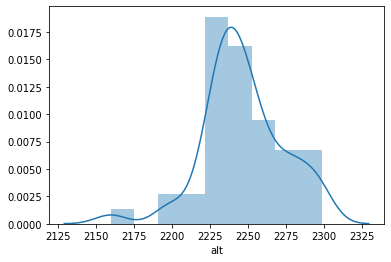

In [ ]:
sns.distplot(df_normalized_converted_stations['alt'])